# Binary prediction of poisonous mushrooms

*Before starting, install the requirements for this notebook*

*To create an environment*

`python -m venv .venv`

*To install the requirements*

`source .venv/bin/activate`

`pip install -r requirements.txt`

Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.options.display.max_columns = None

Loading train and test set

Data can be downloaded [here](https://www.kaggle.com/competitions/playground-series-s4e8/data).

In [6]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train["class"] = train["class"].map({'p': 1, 'e': 0})
train = train.drop(["id"], axis=1)

In [7]:
train.shape

(3116945, 21)

In [8]:
test.shape

(2077964, 21)

## Data analysis

Unique values per column

In [9]:
out = []
for c in train.columns:
    out.append((
        c,
        round(train[c].isnull().sum() / len(train) * 100, 2),
        train[c].nunique(),
        type(train[c].loc[~train[c].isnull()].iloc[0]),
    ))

print("Train set:")
display(pd.DataFrame(out, columns=[
    "col",
    "null_values",
    "n_unique_values",
    "data_type",
]).sort_values("null_values", ascending=False)
)
out = []
for c in test.columns:
    out.append((
        c,
        round(test[c].isnull().sum() / len(test) * 100, 2),
        test[c].nunique(),
        type(test[c].loc[~test[c].isnull()].iloc[0]),
    ))

print("Test set:")
display(pd.DataFrame(out, columns=[
    "col",
    "null_values",
    "n_unique_values",
    "data_type",
]).sort_values("null_values", ascending=False))

Train set:


,col,null_values,n_unique_values,data_type
14,veil-type,94.88,22,<class 'str'>
18,spore-print-color,91.43,32,<class 'str'>
11,stem-root,88.45,38,<class 'str'>
15,veil-color,87.94,24,<class 'str'>
12,stem-surface,63.55,60,<class 'str'>
7,gill-spacing,40.37,48,<class 'str'>
3,cap-surface,21.53,83,<class 'str'>
6,gill-attachment,16.81,78,<class 'str'>
17,ring-type,4.13,40,<class 'str'>
0,class,0.00,2,<class 'numpy.int64'>


Test set:


,col,null_values,n_unique_values,data_type
14,veil-type,94.88,15,<class 'str'>
18,spore-print-color,91.42,33,<class 'str'>
11,stem-root,88.45,31,<class 'str'>
15,veil-color,87.88,23,<class 'str'>
12,stem-surface,63.60,54,<class 'str'>
7,gill-spacing,40.40,35,<class 'str'>
3,cap-surface,21.51,59,<class 'str'>
6,gill-attachment,16.83,66,<class 'str'>
17,ring-type,4.15,36,<class 'str'>
0,id,0.00,2077964,<class 'numpy.int64'>


## Filling null values

In [10]:
tmp = train.isna().sum()
display(tmp.loc[tmp > 0].sort_values(ascending=False).reset_index().set_index("index").T)

tmp = test.isna().sum()
display(tmp.loc[tmp > 0].sort_values(ascending=False).reset_index().set_index("index").T)

index,veil-type,spore-print-color,stem-root,veil-color,stem-surface,gill-spacing,cap-surface,gill-attachment,ring-type,gill-color,habitat,cap-shape,stem-color,has-ring,cap-color,does-bruise-or-bleed,cap-diameter
0,2957493,2849682,2757023,2740947,1980861,1258435,671023,523936,128880,57,45,40,38,24,12,8,4


index,veil-type,spore-print-color,stem-root,veil-color,stem-surface,gill-spacing,cap-surface,gill-attachment,ring-type,gill-color,cap-shape,habitat,stem-color,has-ring,cap-color,does-bruise-or-bleed,cap-diameter,stem-height
0,1971545,1899617,1838012,1826124,1321488,839595,446904,349821,86195,49,31,25,21,19,13,10,7,1


`Filling strings with 'NULL' and numbers with median`

In [11]:
step0 = train.copy()
medians = {}
for c in [c for c in train.columns if train[c].dtype in ['O']]:
    step0[c] = step0[c].fillna("NULL")
for c in [c for c in train.columns if train[c].dtype in ['int', 'float']]:
    medians[c] = step0[c].median()
    step0[c] = step0[c].fillna(medians[c])
    
step0_test = test.copy()
for c in [c for c in test.columns if test[c].dtype in ['O']]:
    step0_test[c] = step0_test[c].fillna("NULL")
for c in [c for c in test.columns if test[c].dtype in ['int', 'float']]:
    if c != "id":
        step0_test[c] = step0_test[c].fillna(medians[c])

In [12]:
out = []
for c in step0.columns:
    out.append((
        c,
        round(step0[c].isnull().sum() / len(step0) * 100, 2),
        step0[c].nunique(),
        type(step0[c].loc[~step0[c].isnull()].iloc[0]),
    ))

print("Train set:")
display(pd.DataFrame(out, columns=[
    "col",
    "null_values",
    "n_unique_values",
    "data_type",
]).sort_values("null_values", ascending=False)
)
out = []
for c in step0_test.columns:
    out.append((
        c,
        round(step0_test[c].isnull().sum() / len(step0_test) * 100, 2),
        step0_test[c].nunique(),
        type(step0_test[c].loc[~step0_test[c].isnull()].iloc[0]),
    ))

print("Test set:")
display(pd.DataFrame(out, columns=[
    "col",
    "null_values",
    "n_unique_values",
    "data_type",
]).sort_values("null_values", ascending=False))

Train set:


,col,null_values,n_unique_values,data_type
0,class,0.0,2,<class 'numpy.int64'>
11,stem-root,0.0,39,<class 'str'>
19,habitat,0.0,53,<class 'str'>
18,spore-print-color,0.0,33,<class 'str'>
17,ring-type,0.0,41,<class 'str'>
16,has-ring,0.0,24,<class 'str'>
15,veil-color,0.0,25,<class 'str'>
14,veil-type,0.0,23,<class 'str'>
13,stem-color,0.0,60,<class 'str'>
12,stem-surface,0.0,61,<class 'str'>


Test set:


,col,null_values,n_unique_values,data_type
0,id,0.0,2077964,<class 'numpy.int64'>
11,stem-root,0.0,32,<class 'str'>
19,habitat,0.0,40,<class 'str'>
18,spore-print-color,0.0,34,<class 'str'>
17,ring-type,0.0,37,<class 'str'>
16,has-ring,0.0,24,<class 'str'>
15,veil-color,0.0,24,<class 'str'>
14,veil-type,0.0,16,<class 'str'>
13,stem-color,0.0,56,<class 'str'>
12,stem-surface,0.0,55,<class 'str'>


## Scaling distributions

Plotting the results of different scaling techniques

/var/folders/xn/8vsljl4926j5qzckqw8v1nkh0000gp/T/ipykernel_4096/1410218703.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/xn/8vsljl4926j5qzckqw8v1nkh0000gp/T/ipykernel_4096/1410218703.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/xn/8vsljl4926j5qzckqw8v1nkh0000gp/T/ipykernel_4096/1410218703.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


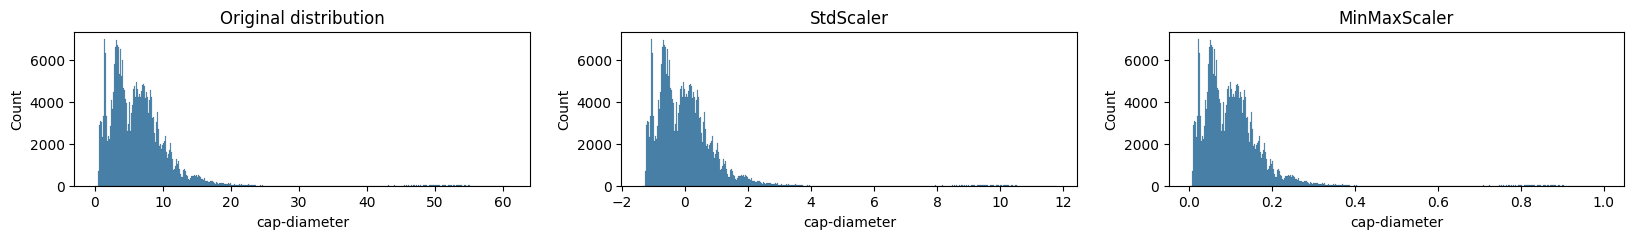

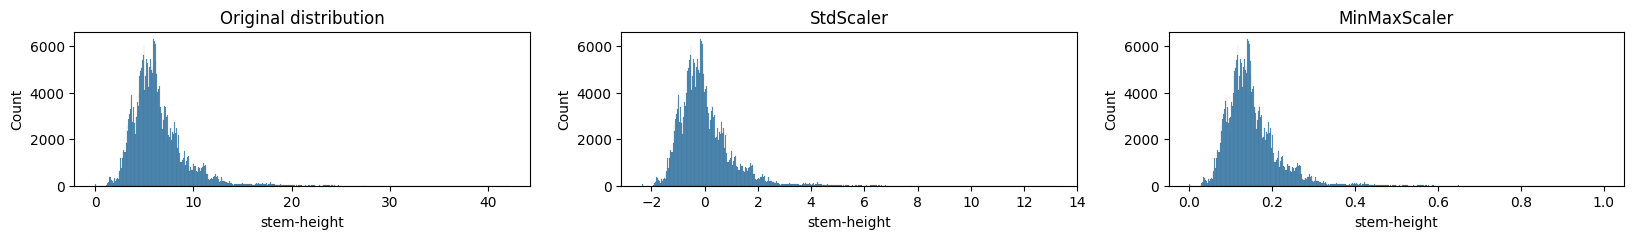

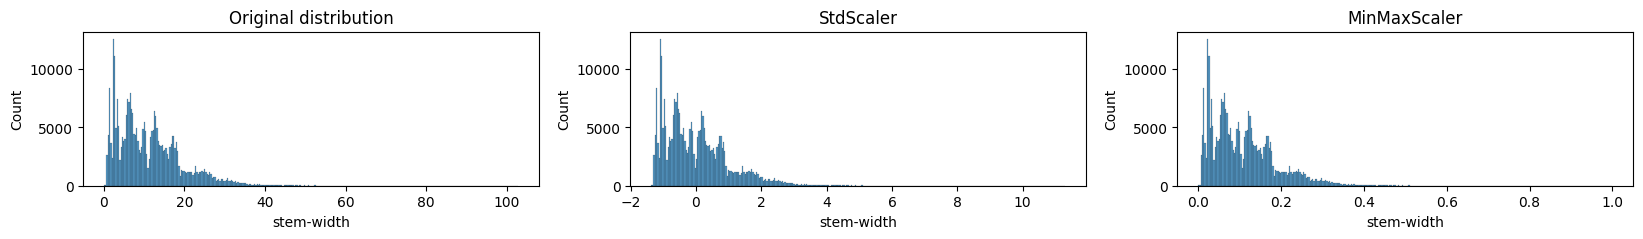

In [10]:
cols = [
    'cap-diameter',
    'stem-height',
    'stem-width'
]

for col in cols:
    tmp = step0.sample(300_000)
    mean_, std_ = tmp[col].mean(), tmp[col].std()
    min_, max_ = tmp[col].min(), tmp[col].max()

    fig, ax = plt.subplots(1, 3, figsize=(20, 2))
    sns.histplot(
        tmp[col],
        ax=ax[0]
    )
    sns.histplot(
        (tmp[col] - mean_) / std_,
        ax=ax[1]
    )
    sns.histplot(
        ((tmp[col]-min_) / (max_-min_)),
        ax=ax[2]
    )
    ax[0].set_title("Original distribution")
    ax[1].set_title("StdScaler")
    ax[2].set_title("MinMaxScaler")
    fig.show()

Scaling using standard scaling (subtricting the mean and dividing by standard deviation)

Each column of the test set is scaled by the corresponding train median and std.

In [13]:
step1 = step0.copy()
step1_test = step0_test.copy()

cols = [
    'cap-diameter',
    'stem-height',
    'stem-width'
]

for c in cols:
    m, s = step1[c].mean(), step1[c].std()
    step1[c] = (step1[c] - m) / s
    step1_test[c] = (step1_test[c] - m) / s

## Encoding categories

One-hot encoding (not used)

In [11]:
# from sklearn.preprocessing import OneHotEncoder

# step2 = step1.copy()

# for c in [c for c in step2.columns if step2[c].dtype == 'O']:
#     print(c)

#     out = OneHotEncoder(min_frequency=0.01, sparse_output=False).fit_transform(step2[[c]])
#     n_cols = out.shape[1]

#     step2 = pd.concat([
#         step2,
#         pd.DataFrame(out, columns=[f"{c}_{i}" for i in range(n_cols)])
#     ], axis=1)

#     step2 = step2.drop(c, axis=1)

Categorical encoding: categorical columns are ordered by their frequencies and encoded

Categories that have < 1% frequency are considered as "Other"

In [14]:
step2 = step1.copy()
step2_test = step1_test.copy()

min_frequency = 1. / 100
# min_frequency = None
min_samples = 5

for c in [c for c in step2.columns if step2[c].dtype == 'O']:
    if min_frequency is not None:
        tmp = round(step2[c].value_counts() / len(step2) * 100, 2)
        tmp = tmp.loc[tmp > min_frequency].sort_values(ascending=False).index.to_list()
    else:
        tmp = step2[c].value_counts()
        tmp = tmp.loc[tmp > min_samples].sort_values(ascending=False).index.to_list()

    mapping = {col: float(i) for i, col in enumerate(tmp)}

    print(c, len(mapping), "categories")

    step2[c] = step2[c].apply(lambda x: mapping.get(x, len(mapping)))
    step2_test[c] = step2_test[c].apply(lambda x: mapping.get(x, len(mapping)))

cap-shape 7 categories
cap-surface 12 categories
cap-color 12 categories
does-bruise-or-bleed 2 categories
gill-attachment 8 categories
gill-spacing 4 categories
gill-color 12 categories
stem-root 6 categories
stem-surface 9 categories
stem-color 13 categories
veil-type 2 categories
veil-color 7 categories
has-ring 2 categories
ring-type 9 categories
spore-print-color 8 categories
habitat 8 categories
season 4 categories


In [15]:
out = []
for c in step2.columns:
    out.append((
        c,
        round(step2[c].isnull().sum() / len(step2) * 100, 2),
        round(step2[c].isna().sum() / len(step2) * 100, 2),
        step2[c].nunique(),
        type(step2[c].loc[~step2[c].isnull()].iloc[0]),
        step2[c].min(),
        step2[c].max(),
        f"{step2[c].mean():.4f}",
        f"{step2[c].std():.4f}"
    ))

print("Train set:")
display(pd.DataFrame(out, columns=[
    "col",
    "null_values",
    "na_values",
    "n_unique_values",
    "data_type",
    "min", "max",
    "mean", "std"
]).sort_values("null_values", ascending=False))

out = []
for c in step2_test.columns:
    out.append((
        c,
        round(step2_test[c].isnull().sum() / len(step2_test) * 100, 2),
        round(step2_test[c].isna().sum() / len(step2_test) * 100, 2),
        step2_test[c].nunique(),
        type(step2_test[c].loc[~step2_test[c].isnull()].iloc[0]),
        step2_test[c].min(),
        step2_test[c].max(),
        f"{step2_test[c].mean():.4f}",
        f"{step2_test[c].std():.4f}",
    ))

print("Test set:")
display(pd.DataFrame(out, columns=[
    "col",
    "null_values",
    "na_values",
    "n_unique_values",
    "data_type",
    "min", "max",
    "mean", "std",
]).sort_values("null_values", ascending=False))

Train set:


,col,null_values,na_values,n_unique_values,data_type,min,max,mean,std
0,class,0.0,0.0,2,<class 'numpy.int64'>,0.000000,1.000000,0.5471,0.4978
11,stem-root,0.0,0.0,7,<class 'numpy.float64'>,0.000000,6.000000,0.2122,0.6708
19,habitat,0.0,0.0,9,<class 'numpy.float64'>,0.000000,8.000000,0.6316,1.2084
18,spore-print-color,0.0,0.0,9,<class 'numpy.float64'>,0.000000,8.000000,0.1906,0.7437
17,ring-type,0.0,0.0,10,<class 'numpy.float64'>,0.000000,9.000000,0.7158,1.6759
16,has-ring,0.0,0.0,3,<class 'numpy.float64'>,0.000000,2.000000,0.2401,0.4272
15,veil-color,0.0,0.0,8,<class 'numpy.float64'>,0.000000,7.000000,0.1949,0.6800
14,veil-type,0.0,0.0,3,<class 'numpy.float64'>,0.000000,2.000000,0.0512,0.2205
13,stem-color,0.0,0.0,14,<class 'numpy.float64'>,0.000000,13.000000,1.4622,2.0004
12,stem-surface,0.0,0.0,10,<class 'numpy.float64'>,0.000000,9.000000,1.0074,1.6628


Test set:


,col,null_values,na_values,n_unique_values,data_type,min,max,mean,std
0,id,0.0,0.0,2077964,<class 'numpy.int64'>,3.116945e+06,5.194908e+06,4155926.5000,599856.6817
11,stem-root,0.0,0.0,7,<class 'numpy.float64'>,0.000000e+00,6.000000e+00,0.2120,0.6699
19,habitat,0.0,0.0,9,<class 'numpy.float64'>,0.000000e+00,8.000000e+00,0.6323,1.2077
18,spore-print-color,0.0,0.0,9,<class 'numpy.float64'>,0.000000e+00,8.000000e+00,0.1908,0.7439
17,ring-type,0.0,0.0,10,<class 'numpy.float64'>,0.000000e+00,9.000000e+00,0.7180,1.6782
16,has-ring,0.0,0.0,3,<class 'numpy.float64'>,0.000000e+00,2.000000e+00,0.2406,0.4276
15,veil-color,0.0,0.0,8,<class 'numpy.float64'>,0.000000e+00,7.000000e+00,0.1961,0.6820
14,veil-type,0.0,0.0,3,<class 'numpy.float64'>,0.000000e+00,2.000000e+00,0.0512,0.2206
13,stem-color,0.0,0.0,14,<class 'numpy.float64'>,0.000000e+00,1.300000e+01,1.4621,1.9977
12,stem-surface,0.0,0.0,10,<class 'numpy.float64'>,0.000000e+00,9.000000e+00,1.0065,1.6628


# Target analysis

Text(0.5, 0.98, 'Correlation against target')

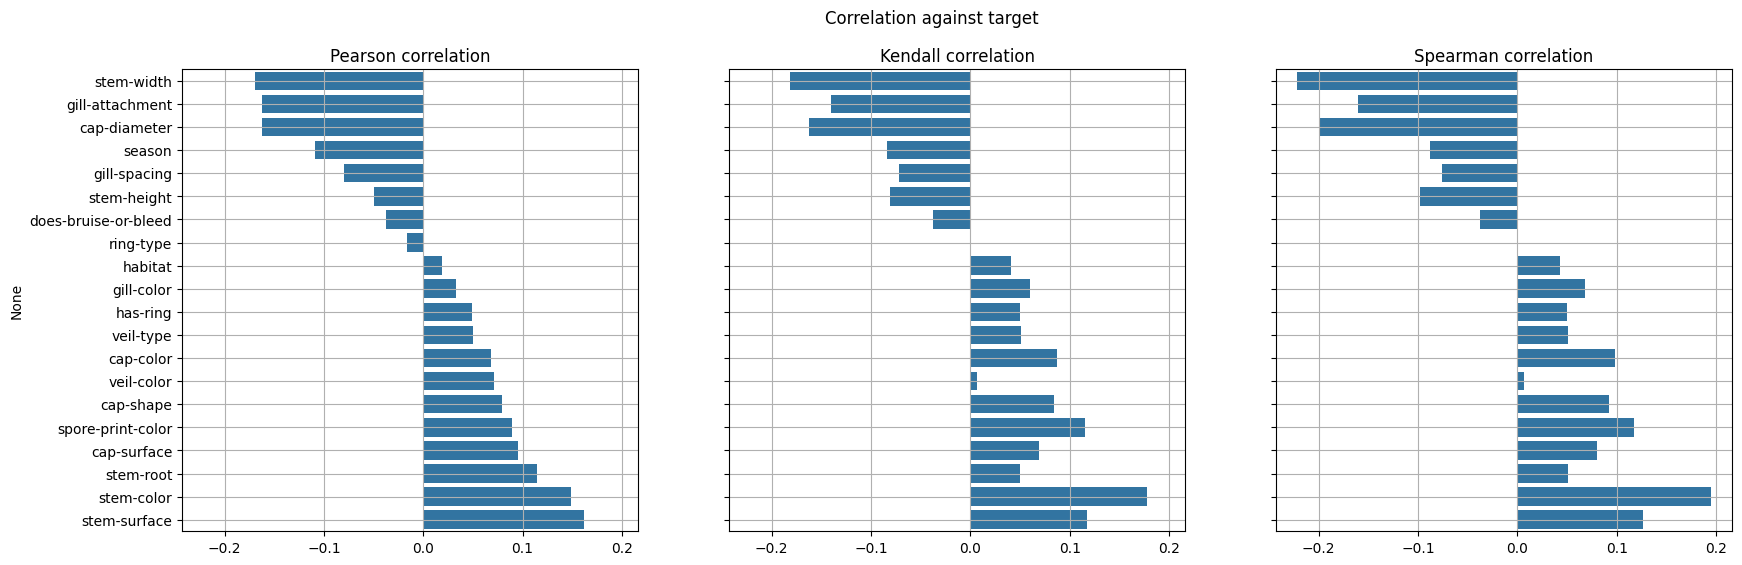

In [18]:
corr_methods = {'pearson', 'kendall', 'spearman'}
fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

for i, method in enumerate(corr_methods):
    tmp = step2[[c for c in step2.columns if c != "class"]].corrwith(step2["class"], method=method).sort_values()
    sns.barplot(
        y=tmp.index,
        x=tmp.to_list(),
        ax=ax[i]
    )
    ax[i].grid()
    ax[i].set_title(f"{method.capitalize()} correlation")
fig.suptitle("Correlation against target")

`Class imbalance`

In [19]:
(step2["class"].value_counts() / len(step2) * 100).round(2).apply(lambda x: f"{x}%").reset_index().set_index("class")

,count
class,
1,54.71%
0,45.29%


# Modelling

Splitting into train and test with 90%-10% splits.

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    step2[[c for c in step2.columns if c != 'class']],
    step2['class'],
    test_size=0.1,
    random_state=0,
    shuffle=True,
    stratify=step2['class']
)

Setting the parameters for grid-search hyperparameter tuning.

Max-depth is set as low values to prevent overfitting.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from itertools import product

param_grid = {
    # "max_depth": [12],
    "max_depth": [2, 5, 8, 10, 12, 15, 20],
    "class_weight": [None],
    "class_weight": ["balanced", None],
    # "n_estimators": [25],
    "n_estimators": [5, 10, 15, 20, 25, 50],
}

combinations = list(product(*list(param_grid.values())))
combinations = [{k: v for k, v in zip(param_grid.keys(), comb)} for comb in combinations]


In [26]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import matthews_corrcoef

final_results = None
for comb in combinations:
    print(comb)
    model = RandomForestClassifier(
        **comb,
        **{
            "criterion": 'gini',
            "max_features": 'sqrt',
            "n_jobs": -1,
            "random_state": 0,
        }
    )
    
    out = cross_validate(
        model, X_train, y_train,
        cv=5,
        return_train_score=True,
        scoring="matthews_corrcoef",
    )

    for param in comb.keys():
        out[param] = [comb[param] for _ in range(len(out["test_score"]))]

    results = pd.concat([
        pd.DataFrame(out[k], columns=[k]) for k in out.keys()
    ], axis=1)

    results = results.reset_index().rename({"index": "split"}, axis=1)

    final_results = pd.concat([final_results, results]) if final_results is not None else results

{'max_depth': 2, 'class_weight': 'balanced', 'n_estimators': 5}
{'max_depth': 2, 'class_weight': 'balanced', 'n_estimators': 10}
{'max_depth': 2, 'class_weight': 'balanced', 'n_estimators': 15}
{'max_depth': 2, 'class_weight': 'balanced', 'n_estimators': 20}
{'max_depth': 2, 'class_weight': 'balanced', 'n_estimators': 25}
{'max_depth': 2, 'class_weight': 'balanced', 'n_estimators': 50}
{'max_depth': 2, 'class_weight': None, 'n_estimators': 5}
{'max_depth': 2, 'class_weight': None, 'n_estimators': 10}
{'max_depth': 2, 'class_weight': None, 'n_estimators': 15}
{'max_depth': 2, 'class_weight': None, 'n_estimators': 20}
{'max_depth': 2, 'class_weight': None, 'n_estimators': 25}
{'max_depth': 2, 'class_weight': None, 'n_estimators': 50}
{'max_depth': 5, 'class_weight': 'balanced', 'n_estimators': 5}
{'max_depth': 5, 'class_weight': 'balanced', 'n_estimators': 10}
{'max_depth': 5, 'class_weight': 'balanced', 'n_estimators': 15}
{'max_depth': 5, 'class_weight': 'balanced', 'n_estimators': 20}

`Adding some metric for overfit`

In [27]:
final_results["overfit"] = final_results["train_score"] - final_results["test_score"]

In [28]:
final_results["class_weight"] = final_results["class_weight"].apply(lambda x: 0 if x == None else 1)

In [30]:
final_results.head(2)

,split,fit_time,score_time,test_score,train_score,max_depth,class_weight,n_estimators,overfit
0,0,0.949044,0.072229,0.368598,0.371499,2,1,5,0.002902
1,1,0.941392,0.054047,0.369651,0.368633,2,1,5,-0.001018


/var/folders/xn/8vsljl4926j5qzckqw8v1nkh0000gp/T/ipykernel_19355/2204005112.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/xn/8vsljl4926j5qzckqw8v1nkh0000gp/T/ipykernel_19355/2204005112.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/xn/8vsljl4926j5qzckqw8v1nkh0000gp/T/ipykernel_19355/2204005112.py:59: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


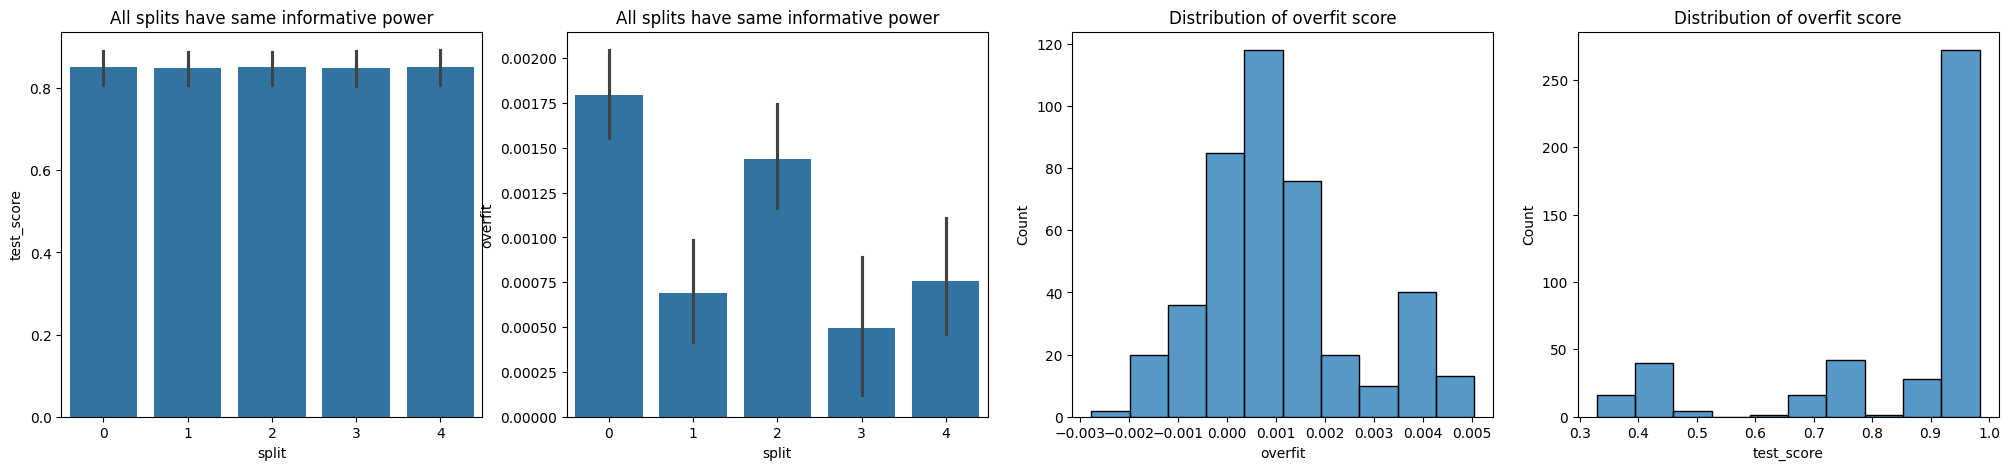

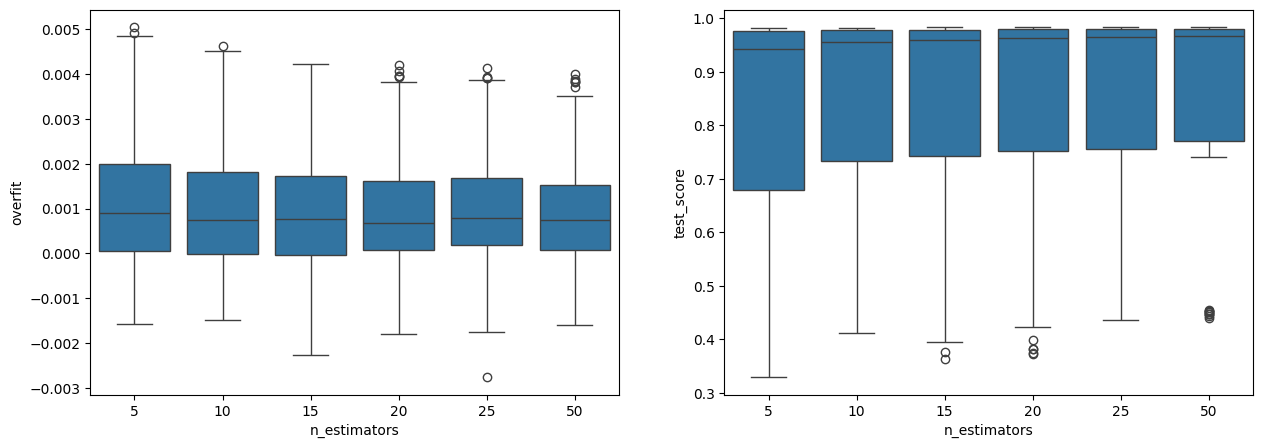

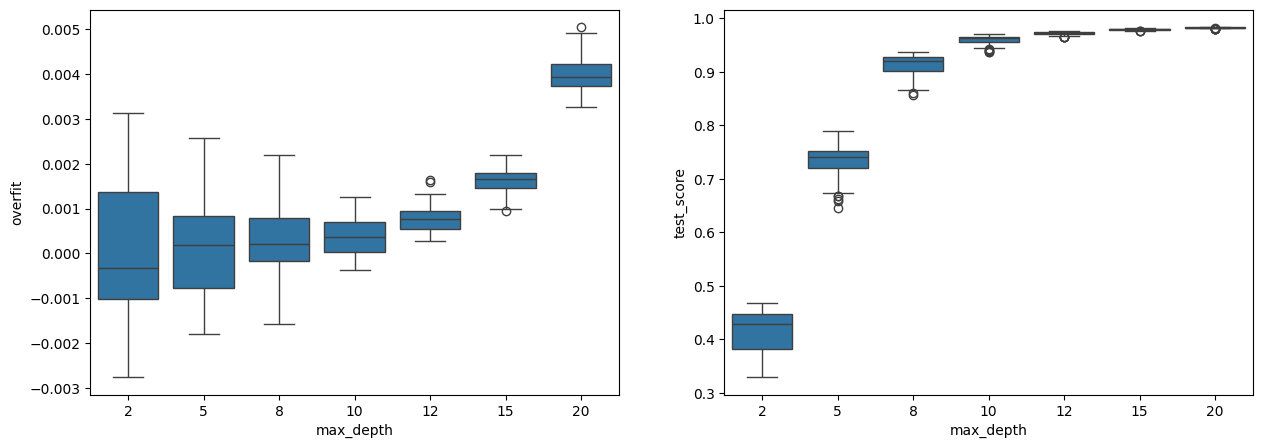

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5))

sns.barplot(
    data=final_results,
    x='split',
    y='test_score',
    ax=ax[0]
)
ax[0].set_title("All splits have same informative power")

sns.barplot(
    data=final_results,
    x='split',
    y='overfit',
    ax=ax[1]
)
ax[1].set_title("All splits have same informative power")

sns.histplot(final_results["overfit"], ax=ax[2], bins=10)
ax[2].set_title("Distribution of overfit score")

sns.histplot(final_results["test_score"], ax=ax[3], bins=10)
ax[3].set_title("Distribution of overfit score")

fig.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
sns.boxplot(
    data=final_results,
    x="n_estimators",
    y="overfit",
    ax=ax[0],
)

sns.boxplot(
    data=final_results,
    x="n_estimators",
    y="test_score",
    ax=ax[1],
)

fig.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
sns.boxplot(
    data=final_results,
    x="max_depth",
    y="overfit",
    ax=ax[0],
)

sns.boxplot(
    data=final_results,
    x="max_depth",
    y="test_score",
    ax=ax[1],
)

fig.show()

Searching for best hyperparameters

In [33]:
tmp = (
    final_results
    # .loc[final_results["max_depth"] == 12]
    # .loc[final_results["overfit"] <= 0.0010]
    .groupby(["n_estimators", "max_depth", "class_weight"])
    .agg(**{
        "median_test_score": ("test_score", np.median),
        "median_overfit": ("overfit", np.median)
    })
    .reset_index()
)

display(tmp.sort_values("median_test_score", ascending=False).head(10))

/var/folders/xn/8vsljl4926j5qzckqw8v1nkh0000gp/T/ipykernel_19355/1806873223.py:2: FutureWarning: The provided callable <function median at 0x1062e4790> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  final_results


,n_estimators,max_depth,class_weight,median_test_score,median_overfit
83,50,20,1,0.983375,0.003714
82,50,20,0,0.983355,0.003819
68,25,20,0,0.983200,0.003877
69,25,20,1,0.983119,0.003836
54,20,20,0,0.983020,0.003952
55,20,20,1,0.982975,0.003830
40,15,20,0,0.982905,0.004068
41,15,20,1,0.982757,0.003934
26,10,20,0,0.982502,0.004308
27,10,20,1,0.982132,0.004292


# Final model

In [34]:
final_model = RandomForestClassifier(
    **{
        "n_estimators": 50,
        "max_depth": 20,
        "class_weight": "balanced",
        "criterion": 'gini',
        "max_features": 'sqrt',
        "n_jobs": -1,
        "random_state": 0,
    }
)

final_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=50,
                       n_jobs=-1, random_state=0)

Evaluating for [Matthews Correlation coefficient](https://en.wikipedia.org/wiki/Phi_coefficient) as it will be used as scoring system for the competition

In [35]:
from sklearn.metrics import f1_score, matthews_corrcoef

print(
    round(matthews_corrcoef(
        y_test,
        final_model.predict(X_test)
    ) * 100, 4), '%'
)

98.4049 %


Checking if train and test distributions are equal

/var/folders/xn/8vsljl4926j5qzckqw8v1nkh0000gp/T/ipykernel_4096/3846531073.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/xn/8vsljl4926j5qzckqw8v1nkh0000gp/T/ipykernel_4096/3846531073.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/xn/8vsljl4926j5qzckqw8v1nkh0000gp/T/ipykernel_4096/3846531073.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/xn/8vsljl4926j5qzckqw8v1nkh0000gp/T/ipykernel_4096/3846531073.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/xn/8vsljl4926j5qzckqw8v1nkh0000gp/T/ipykernel_4096/3846531073.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/xn/8vsljl4926j5qzckqw8v1nkh0000gp/T/ipykernel_4096/3846531073.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown

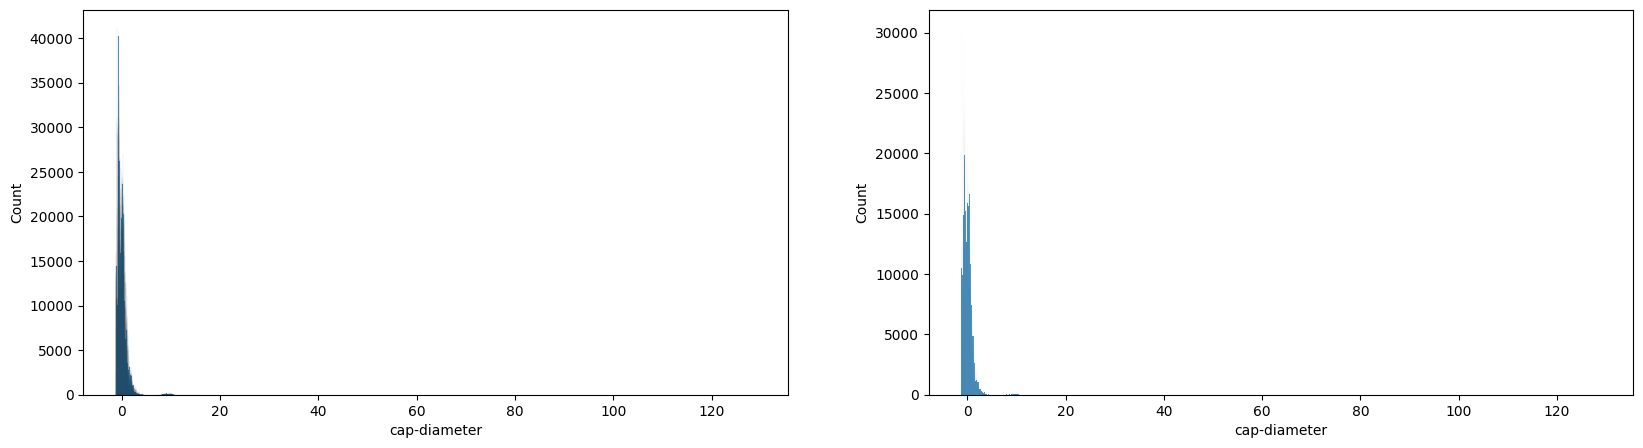

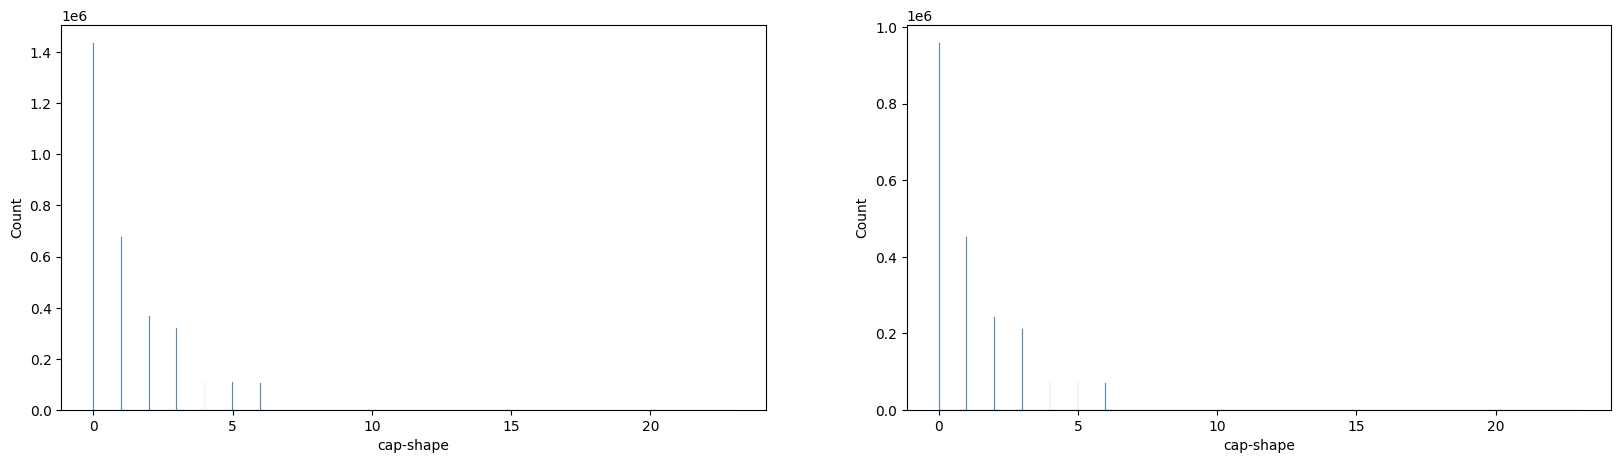

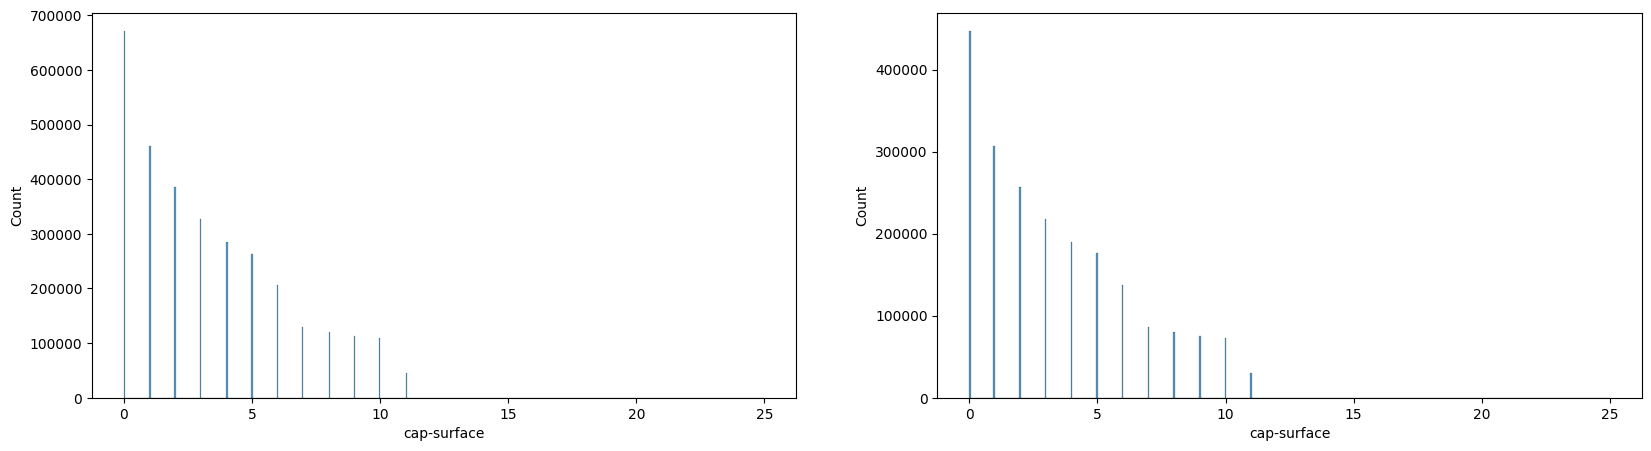

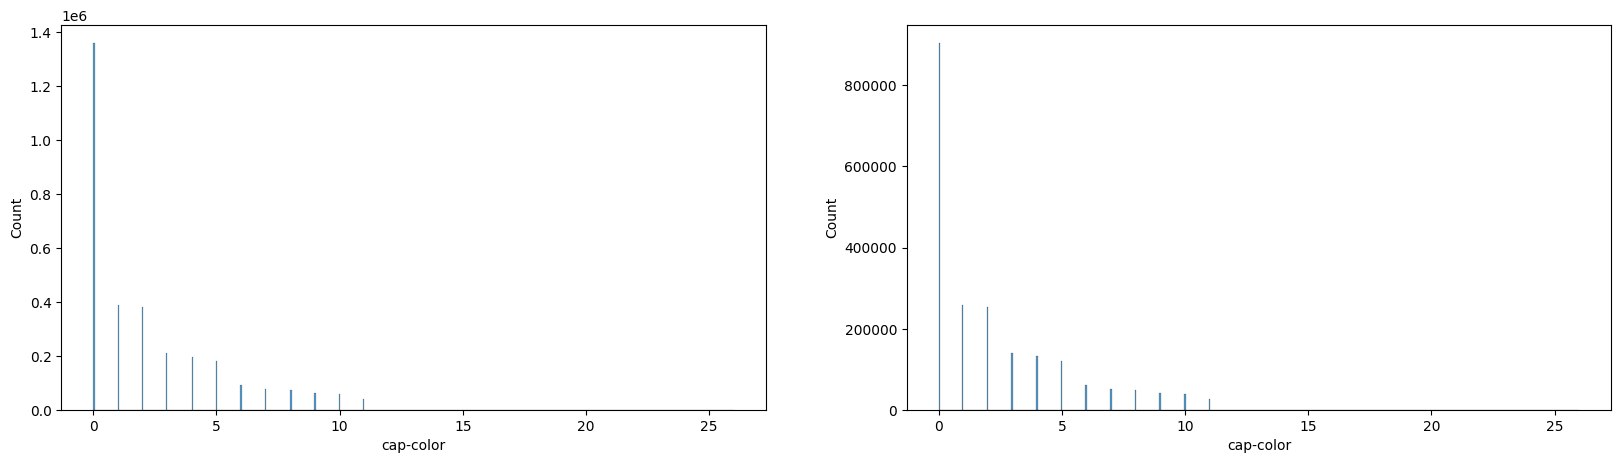

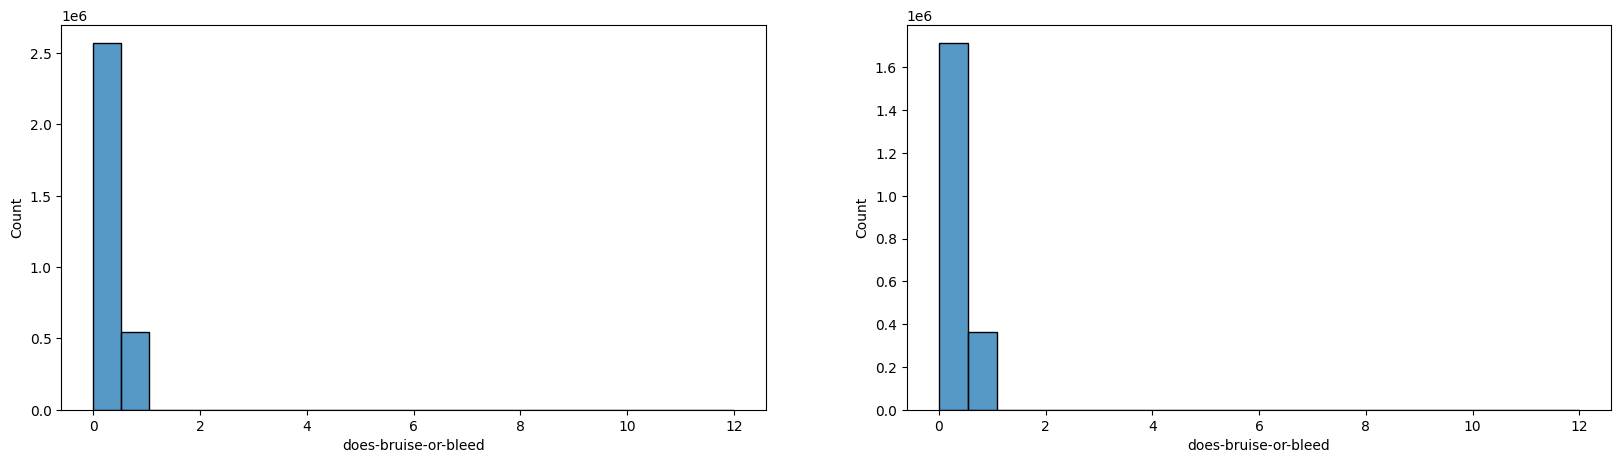

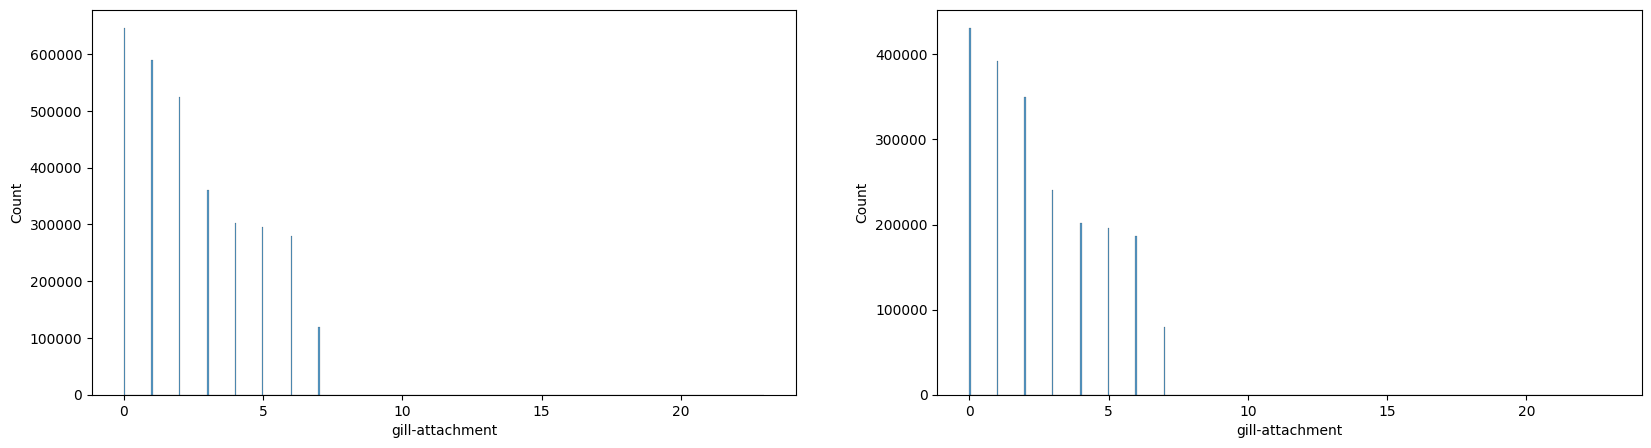

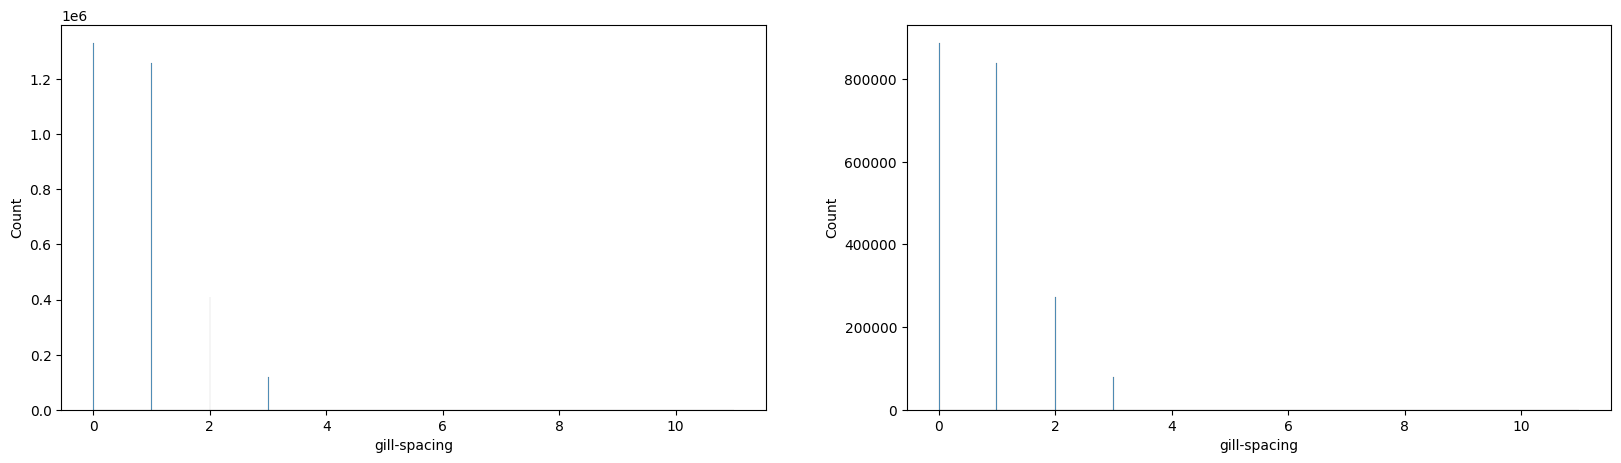

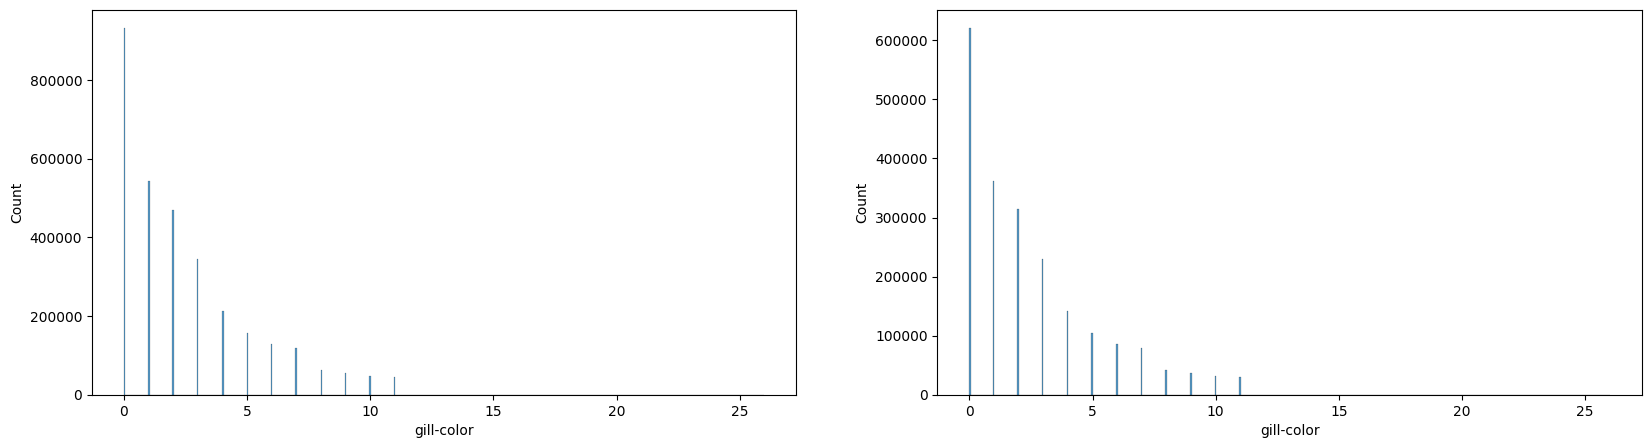

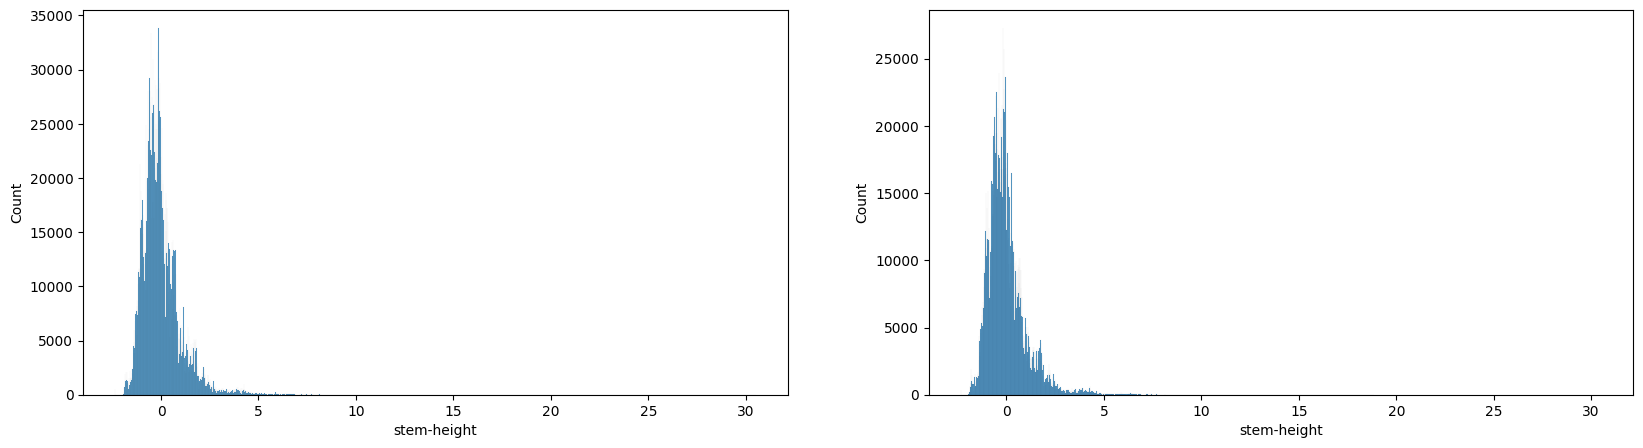

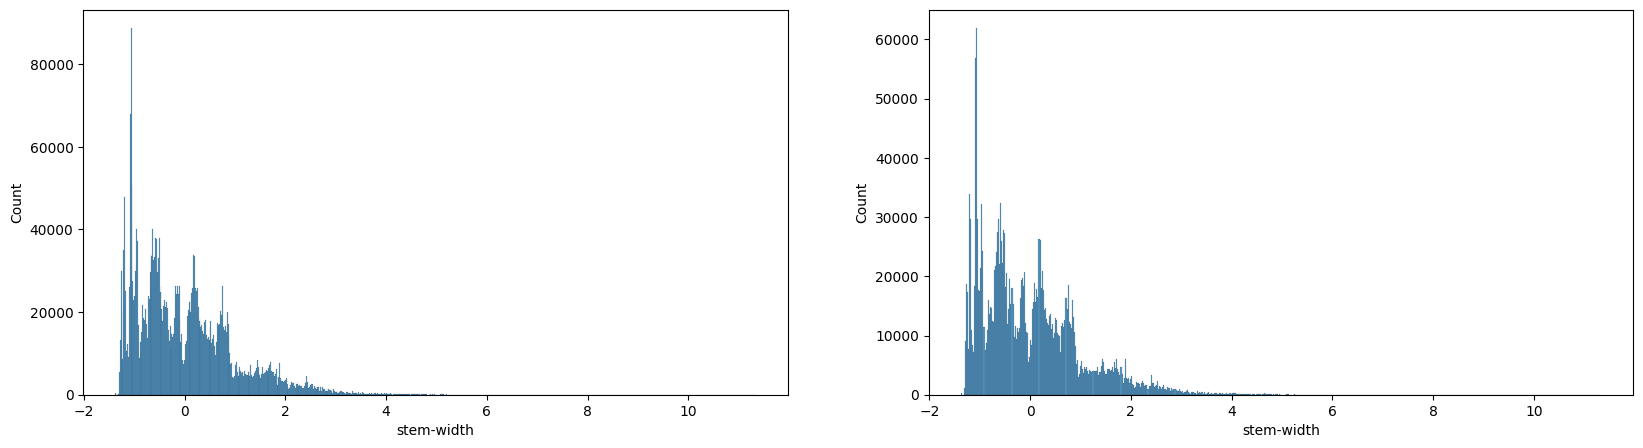

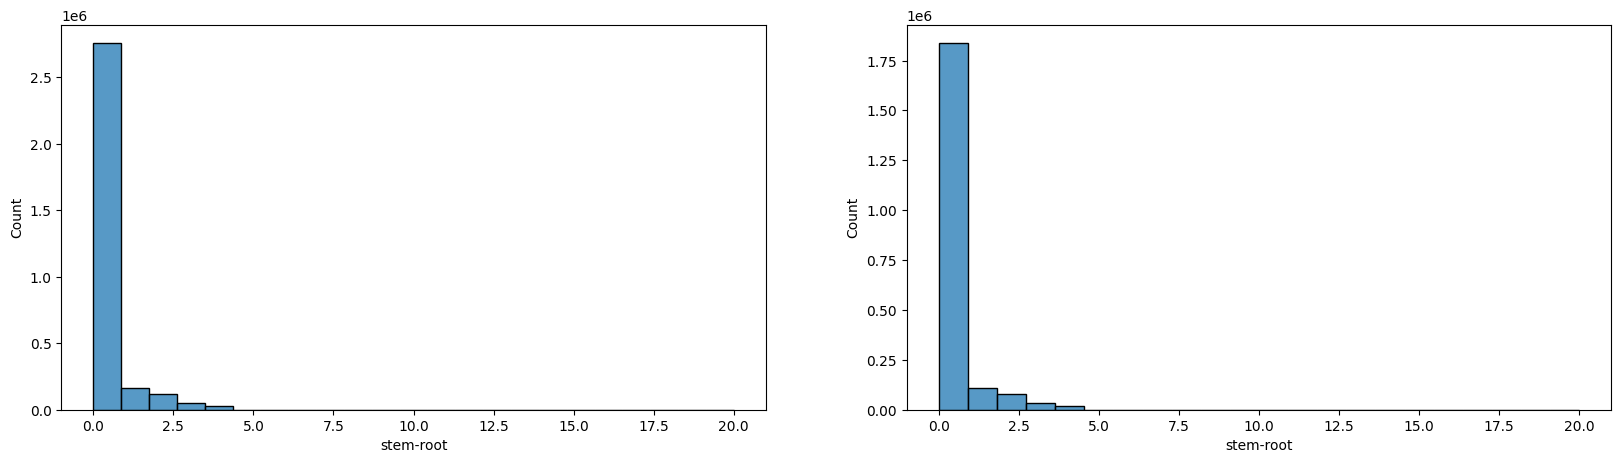

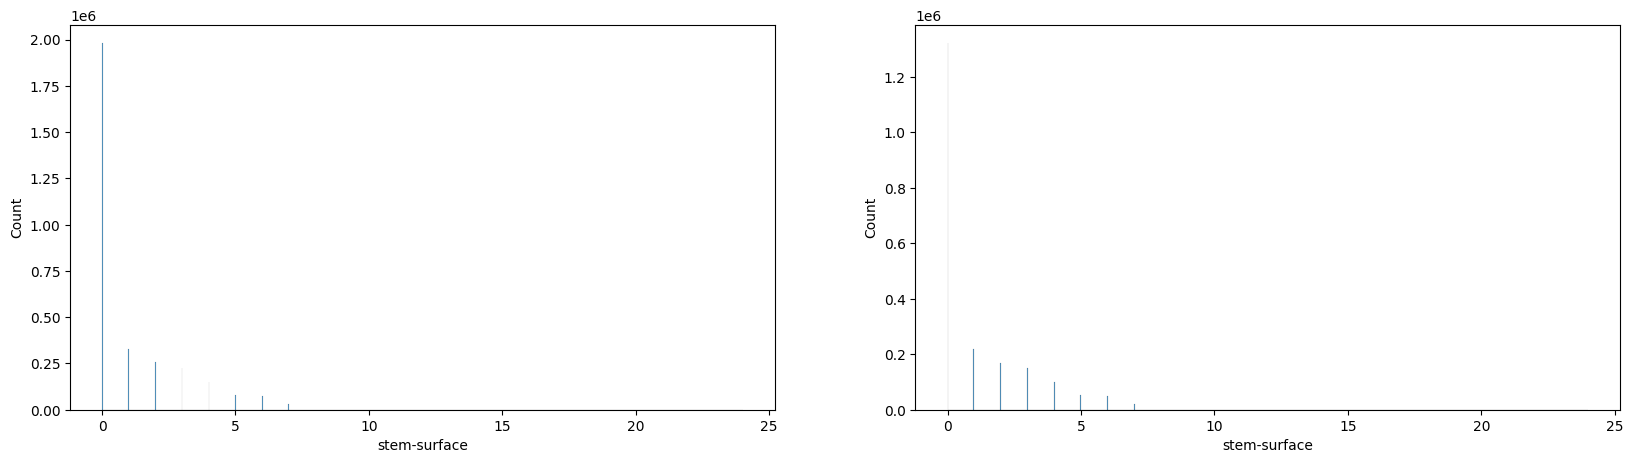

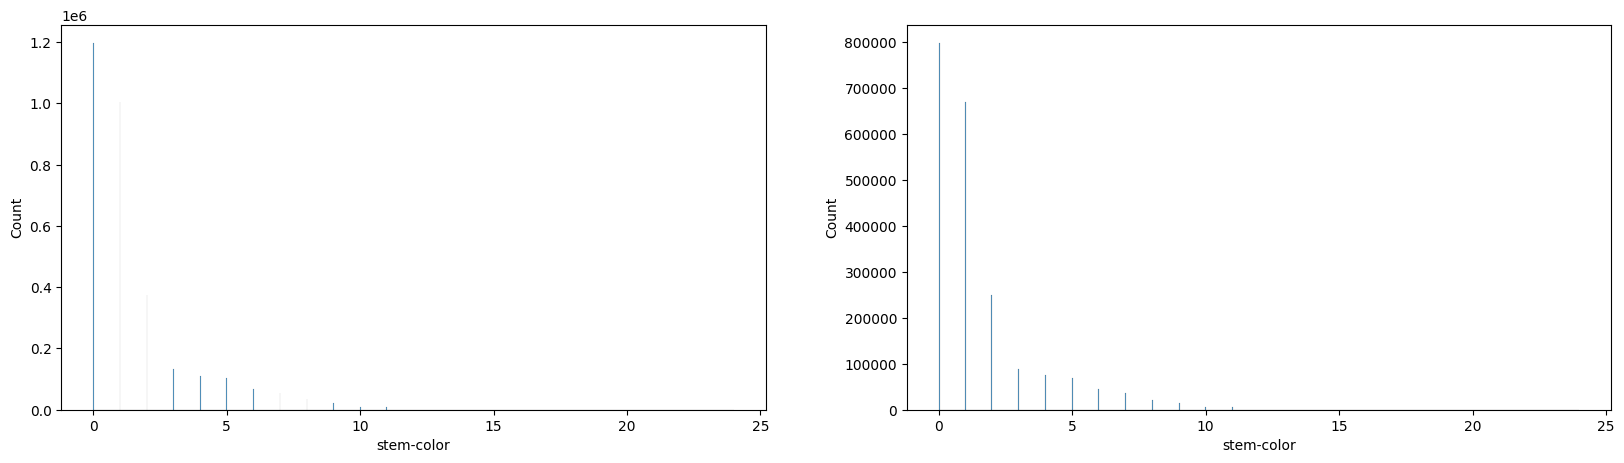

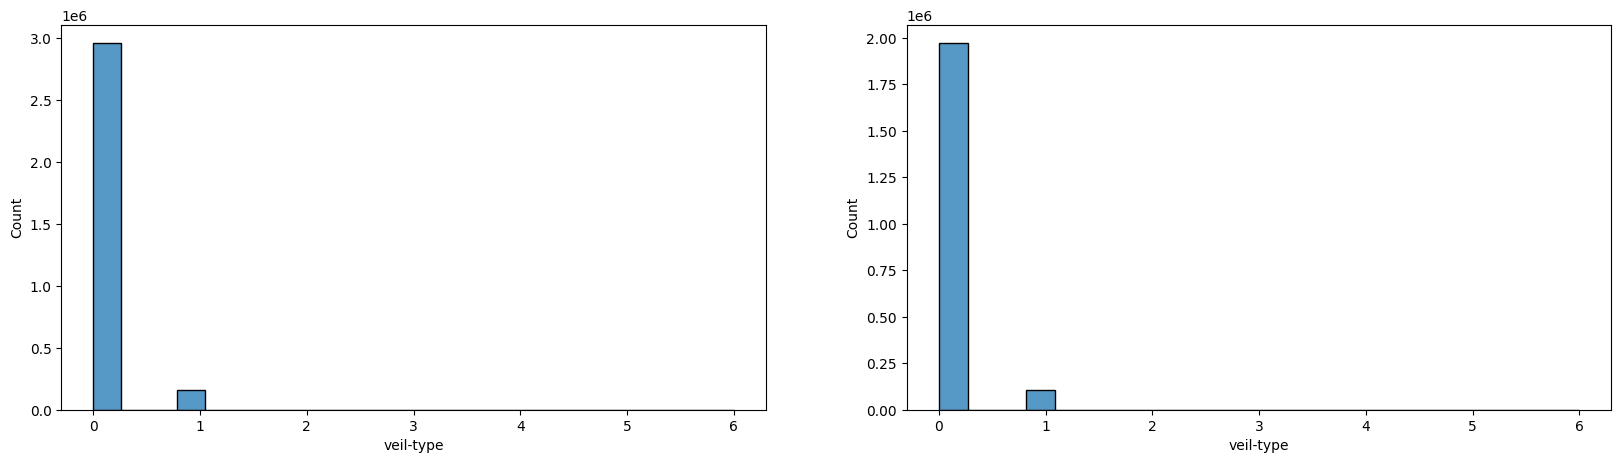

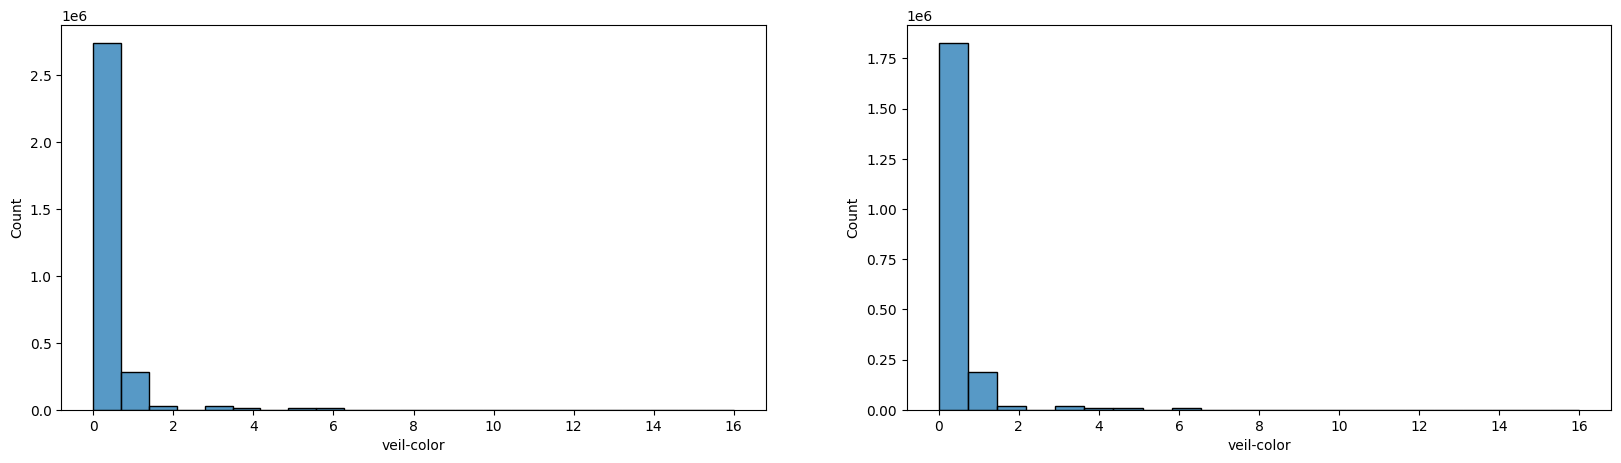

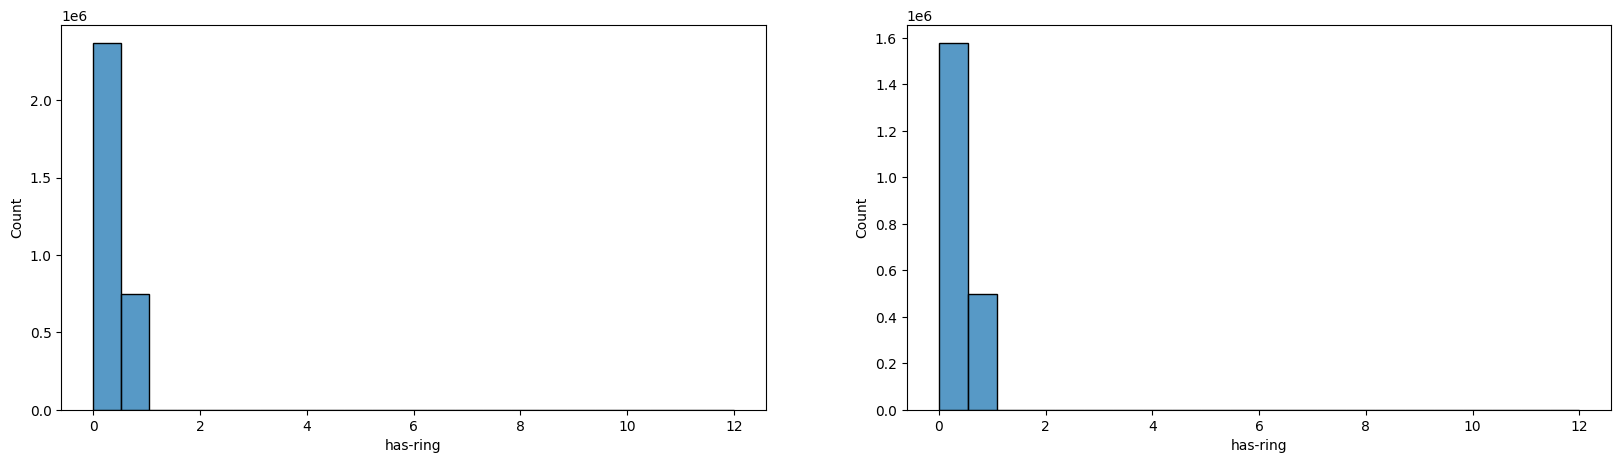

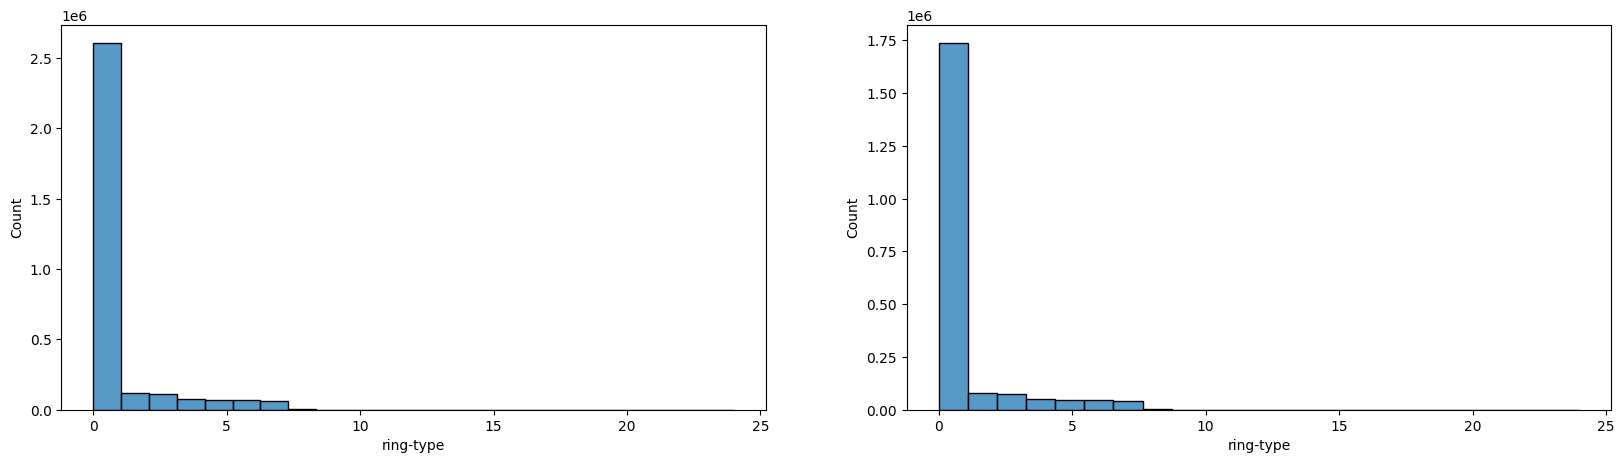

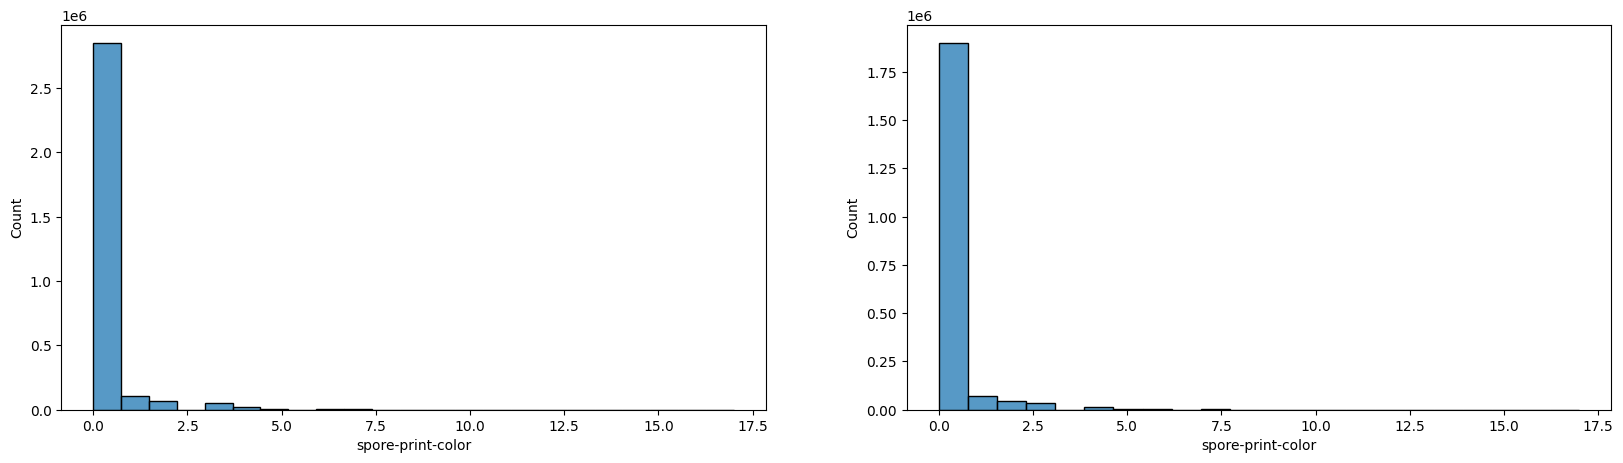

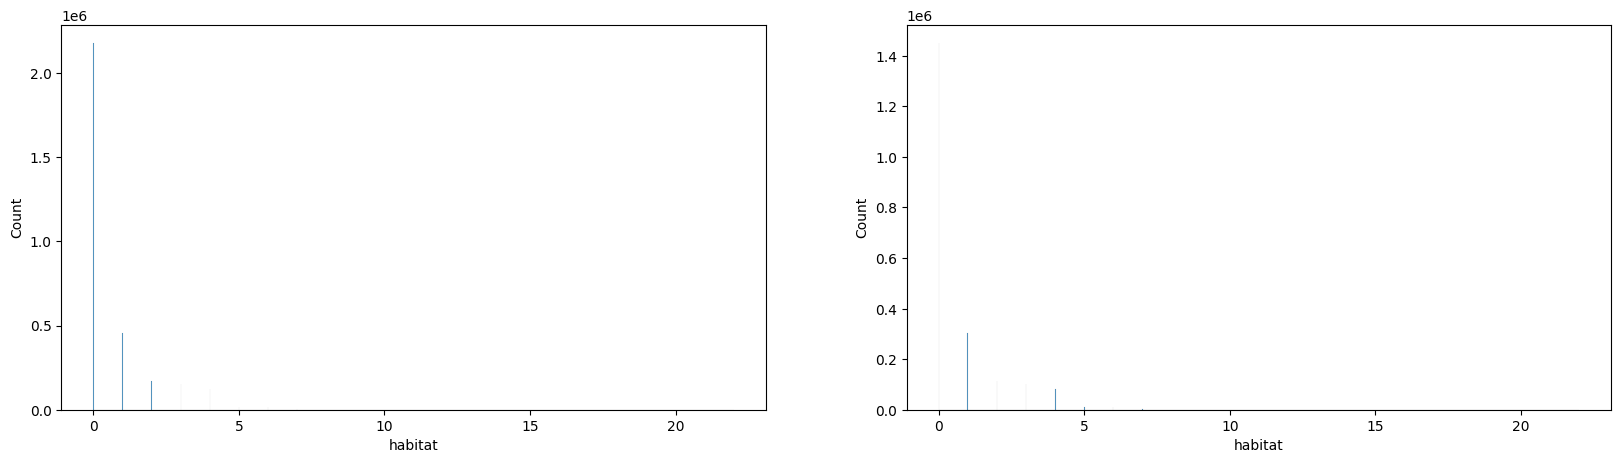

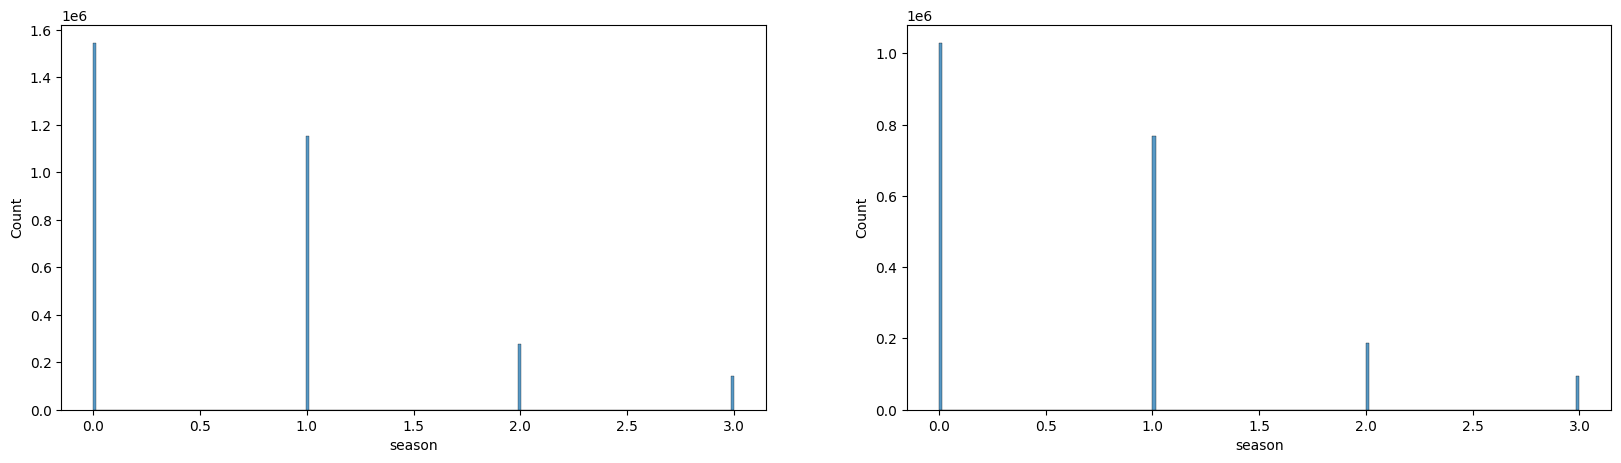

In [31]:
for c in step2.columns:
    if c in ["id", "class"]:
        continue

    fig, ax = plt.subplots(1, 2, figsize=(20, 5), sharex=True)
    sns.histplot(
        step2[c],
        ax=ax[0]
    )

    sns.histplot(
        step2_test[c],
        ax=ax[1]
    )

    fig.show()

## Generating test predictions to submit

In [32]:
step2_test["class"] = (
    pd.Series(
        final_model.predict(step2_test[[c for c in step2_test.columns if c not in ['id', 'class']]])
    )
    .map({1: 'p', 0: 'e'})
)

step2_test

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,class
0,3116945,0.500255,0.0,0.0,0.0,1.0,2.0,1.0,0.0,1.771148,0.736981,1.0,0.0,0.0,1.0,1.0,1.0,7.0,0.0,0.0,0.0,e
1,3116946,0.126698,4.0,1.0,5.0,0.0,2.0,0.0,2.0,-1.881035,-0.049878,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,p
2,3116947,-0.925272,3.0,5.0,0.0,0.0,2.0,0.0,1.0,-0.062351,-0.989909,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,p
3,3116948,-0.609681,0.0,1.0,0.0,0.0,5.0,0.0,1.0,-0.506836,-0.326576,0.0,0.0,0.0,0.0,3.0,1.0,3.0,0.0,0.0,1.0,p
4,3116949,-0.030024,0.0,4.0,1.0,0.0,6.0,1.0,2.0,0.141371,0.314523,0.0,0.0,2.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077959,5194904,-1.165722,0.0,5.0,2.0,0.0,0.0,2.0,0.0,-1.362469,-1.211020,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,p
2077960,5194905,-0.684821,0.0,2.0,2.0,0.0,1.0,0.0,0.0,-1.355061,-0.466160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,p
2077961,5194906,-0.124486,0.0,8.0,4.0,0.0,0.0,1.0,0.0,-0.069759,-0.174639,0.0,0.0,2.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,p
2077962,5194907,-0.274768,3.0,5.0,0.0,0.0,0.0,2.0,4.0,-0.129024,-0.950381,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,e


In [33]:
step2_test[["id", "class"]].to_csv("submission.csv", index=False)

# Appendix

/var/folders/xn/8vsljl4926j5qzckqw8v1nkh0000gp/T/ipykernel_2791/1754312020.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data=tmp[[col, "filler_number__class"]].fillna("NULL"),
/var/folders/xn/8vsljl4926j5qzckqw8v1nkh0000gp/T/ipykernel_2791/1754312020.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data=tmp[[col, "filler_number__class"]].fillna("NULL"),
/var/folders/xn/8vsljl4926j5qzckqw8v1nkh0000gp/T/ipykernel_2791/1754312020.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a f

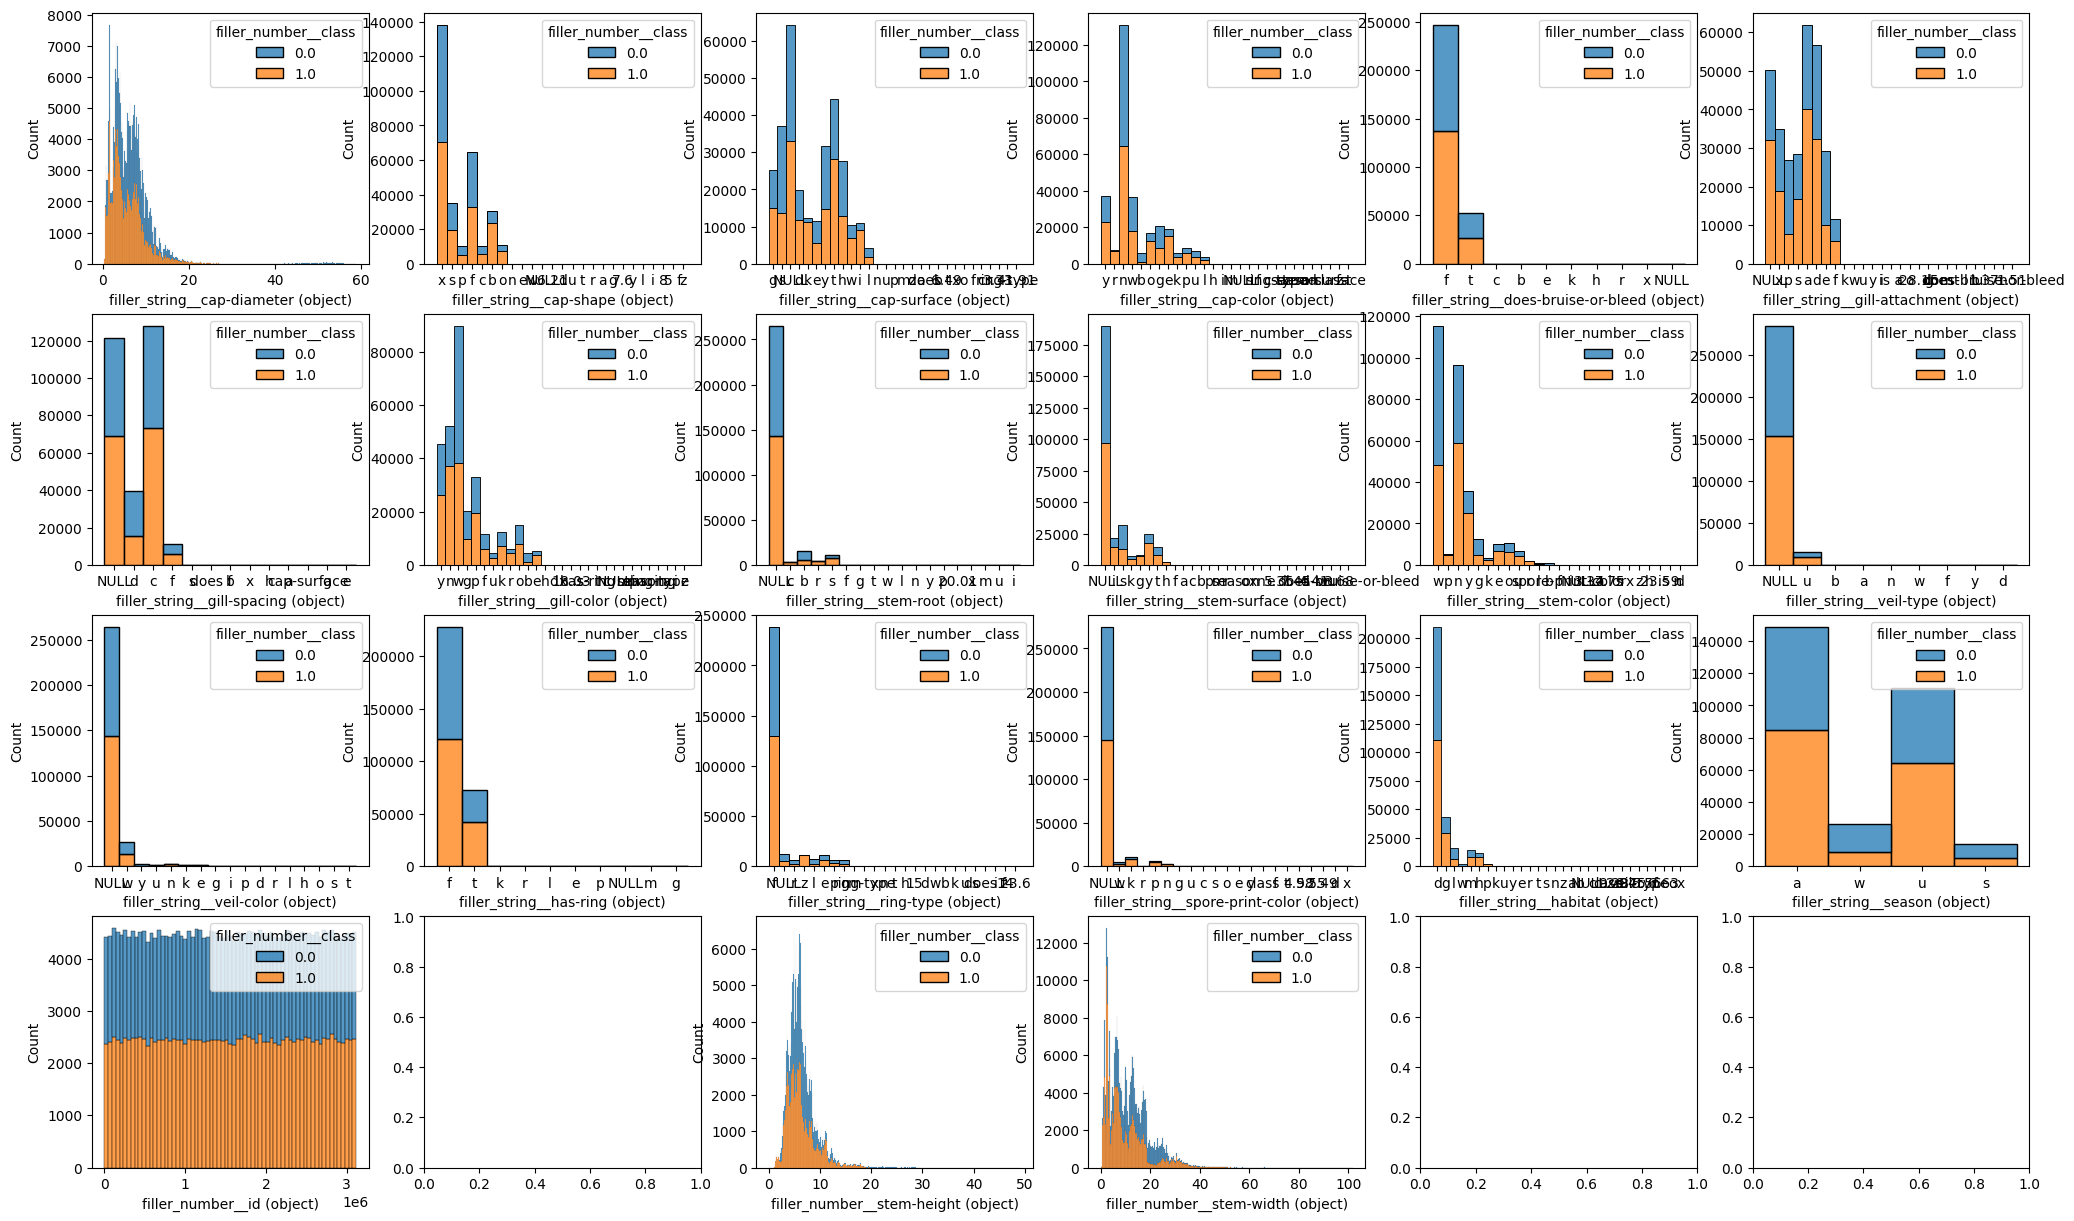

In [75]:
tmp = train.sample(300_000)
n_cols_plot = 6
fig, ax = plt.subplots(len(train.columns) // n_cols_plot + 1, n_cols_plot, figsize=(25,15))

for i, col in enumerate(train.columns.to_list()):
    if col == "filler_number__class":
        continue
    ax_ = ax[i // n_cols_plot][i % n_cols_plot]
    ax_.set_xlabel(f"{col} ({train[col].dtype})")
    sns.histplot(
        data=tmp[[col, "filler_number__class"]].fillna("NULL"),
        x=col,
        hue="filler_number__class",
        multiple="stack",
        ax=ax_
    )

fig.show()